# TP3 : Équations différentielles
## PHY-3500: Physique numérique (H2021) - 19 mars 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [1]:
#import packages
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt

### Mécaniques céleste - comètes

#### Question a)

L'équation différentielle qui régit le mouvement du système comète-soleil est donné par:
$$ m \dfrac{d^2\textbf{r}}{dt^2} = - \left (\dfrac{GMm}{r^2} \right ) \dfrac{\textbf{r}}{r} $$

Puisqu'on considère que le mouvement est confiné dans un plan, les deux dimensions nécessaires pour décrire le mouvement sont données par les équations suivantes:
$$ \dfrac{d^2x}{dt^2} = -GM \dfrac{x}{r^3} $$


$$ \dfrac{d^2 y}{dt^2} = -GM \dfrac{y}{r^3} $$

Pour simplifier la démarche analytique, il est préférable de réécrire ces deux équations différentielles du deuxième ordre en quatre équations différentielles du premier ordre en utilisant un changement de variable suivant:

$$ \dfrac{dx}{dt} = v_x   \hspace{2cm}  \dfrac{dv_x}{dt} = -GM \dfrac{x}{r^3} $$

$$ \dfrac{dy}{dt} = v_y   \hspace{2cm}   \dfrac{dv_y}{dt} = -GM \dfrac{y}{r^3} $$

#### Question b)

31560.0


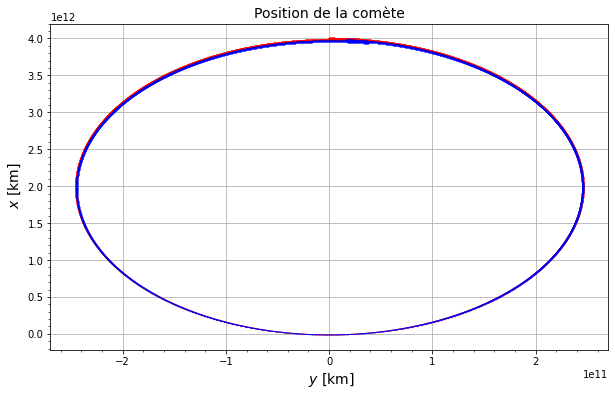

In [25]:
def f(r,t):
    G = const.G
    M = const.M_sun
    
    x, y, vx, vy = r
    R = np.sqrt(x**2 + y**2)

    f_x = vx
    f_y = vy
    f_vx = -G.value*M.value*x*R**-3
    f_vy = -G.value*M.value*y*R**-3
    
    return np.array([f_x, f_y, f_vx, f_vy], float)

a = 0
b = 3.156e7*100
N = 100_000
h = (b-a)/N
print(h)

tpoints = np.arange(a, b, h)
xpoints = []
ypoints = []

x0 = 4*10**12
y0 = 0
vx0 = 0
vy0 = 500 

r = np.array([x0, y0, vx0, vy0], float)
for t in tpoints:
    xpoints.append(r[0])
    ypoints.append(r[1])
    
    k1 = h*f(r, t)
    k2 = h*f(r+0.5*k1, t+0.5*h)
    k3 = h*f(r+0.5*k2, t+0.5*h)
    k4 = h*f(r+k3, t+h)
    
    r += (k1 + 2*k2 + 2*k3 + k4)/6
    
    
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ypoints, xpoints = np.asarray(ypoints), np.asarray(xpoints)

line1, = ax.plot(np.split(ypoints, 2)[0], np.split(xpoints, 2)[0], marker='o', color='r', lw=1, markersize=0.1)
line2, = ax.plot(np.split(ypoints, 2)[1], np.split(xpoints, 2)[1], marker='o', color='b', lw=1, markersize=0.1)

ax.set_title("Position de la comète", fontsize=14)
ax.set_xlabel(" $y$ [km]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $x$ [km]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)

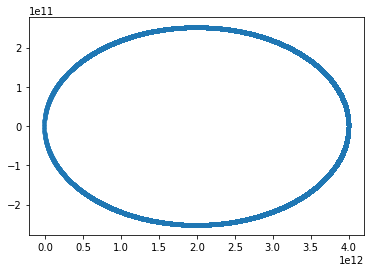

In [5]:
# Exercice 8.10 


# Created on Sat Aug 17 10:57:02 2013
# @author: akels
# """
# from __future__ import division, print_function
# from os import sys
# sys.path.append('cpresources')
# from pylab import *
# from math import sqrt

class rksolve:
	
	def __init__(self,f):
		
		self.f = f #self.array_decorator(f)
		
		self.initial_conditions = None
		self.solution = None
		
	def iterate(self,a,b,N=100000):
		
		#f = self.f
		r0 = np.array(self.initial_conditions,float)
		
		h = (b-a)/N
		
		tpoints = np.arange(a,b,h)
		solution = np.empty(tpoints.shape + r0.shape,float)
		
		#r_points[0] = r0
		r = r0
		for i,t in enumerate(tpoints):
		    solution[i]=r
		    r += self.estimate_delta(r,t,h)
		
		self.h = h
		self.solution = solution
		self.t = tpoints
		
	def estimate_delta(self,r,t,h):
		
		f = self.f
		k1 = h*f(r,t)
		k2 = h*f(r+0.5*k1,t+0.5*h)
		k3 = h*f(r+0.5*k2,t+0.5*h)
		k4 = h*f(r+k3,t+h)
		return (k1+2*k2+2*k3+k4)/6

class rksolve_adaptive(rksolve):
	
	def iterate(self,a,b,delta=1):
		
		
		r0 = np.array(self.initial_conditions,float)
		
		h = (b-a)/10000
		solution = []
		time = []
		r = r0
		t = a
		
		solution.append(np.copy(r))
		time.append(t)
		
		ro = 1
		while t<b:	
			if ro<2:
				h = h*ro**(1/4)
			else:
				h*=2
			# estimating ro
			r1 = r + self.estimate_delta(r,t,h)
			r1 += self.estimate_delta(r1,t+h,h)			
			r2 = r + self.estimate_delta(r,t,2*h)
			difference = r1 - r2
			ro = 30*h*delta/np.sqrt(difference[0]**2 + difference[1]**2)
			
			if ro>1:
				t +=2*h
				r = r1
				solution.append(np.copy(r))
				time.append(t)
			
		
		self.h = h
		self.solution = np.array(solution)
		self.t = time


G = 6.67e-11
M = 1.9e30

def f(r,t):
	
	x,y,vx,vy = r
	
	Dx = vx
	Dy = vy
	
	R = np.sqrt(x**2 + y**2)
	
	Dvx = -G*M*x/R**3
	Dvy = -G*M*y/R**3
	
	return np.array([Dx,Dy,Dvx,Dvy],float)
	
prob = rksolve(f)
# prob = rksolve_adaptive(f)


R = 1.496e11
T = 3.156e7 
v = 2*np.pi*R/T
prob.initial_conditions = [4e12,0,0,500]

delta = 1e3/365/24/60/60
prob.iterate(0,T*50)
# prob.iterate(0, T*50, delta=delta)

x = prob.solution[:,0]
y = prob.solution[:,1]

plt.plot(x,y,'.')
plt.show()

#### Question c)

### Mécanique céleste - la Terre

#### Question d)

#### Question e)

#### Question f)

#### Question g)

### Mécanique céleste - Mars

#### Question h)